In [1]:
# This code uses slope based elimination method for the lines

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
directory = 'test_images/'
os.listdir(directory)
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
image = mpimg.imread('test_images/solidYellowLeft.jpg')
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


In [2]:
#image = cv2.imread('test_images/whiteCarLaneSwitch.jpg')
#cv2.imwrite('test_images_results/Test_gray.jpg', image)

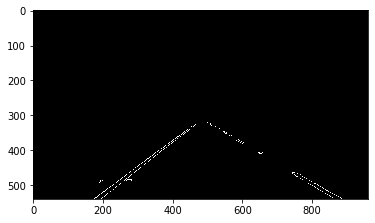

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 50
high_threshold = 150
masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(masked_edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(490, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(masked_edges, mask)

# Display the image
plt.imshow(masked_edges, cmap='Greys_r')

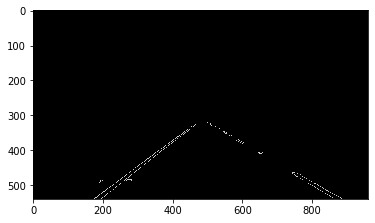

In [4]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2
theta = 1*np.pi/180
threshold = 15
min_line_length = 20
max_line_gap = 25
line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(0,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)

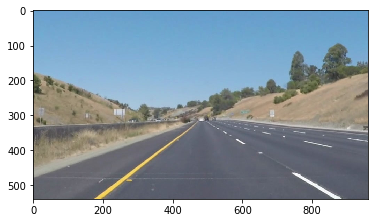

In [5]:
ResultImage = cv2.addWeighted(image, 1, line_image, 1, 0) 
plt.imshow(ResultImage)
#plt.savefig('test_images_results/ResultImage.jpg')

In [6]:
#for line in lines:
#    for x1,y1,x2,y2 in line:
#        cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
#image = cv2.imread('test_images/whiteCarLaneSwitch.jpg')
#ResultImage = cv2.addWeighted(image, 1, line_image, 1, 0) 
#cv2.imshow('image',ResultImage)
#cv2.waitKey(0)
#cv2.imwrite('test_images_results/Test_gray.jpg', ResultImage)

In [7]:
def draw_lines(img, lines, color, thickness):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(0,0,0),1)
    ###
    i = 0
    a = [[0] * len(lines), [0] * len(lines)]
    for pltline in lines:
        for x1,y1,x2,y2 in pltline:
            plt.plot([x1, x2], [y1, y2])
            a[0][i] = ((y2-y1)/(x2-x1))
            a[1][i] = ((y2-y1)**2 + (x2-x1)**2)**(1/2)
            i = i + 1
    ###
    aPos = [i for i in a[0] if i > 0]
    aPosLen = [a[1][a[0].index(i)] for i in a[0] if i > 0]
    aNeg = [i for i in a[0] if i <= 0]
    aNegLen = [a[1][a[0].index(i)] for i in a[0] if i <= 0]
    aAveAbs = sum(list(map(abs, a[0])))/len(a[0])
    ###
    aNegX = [i for i in aNeg if abs(abs(i)-aAveAbs)<0.2]
    aNegLenX = [a[1][a[0].index(i)] for i in aNegX]
    AveNegRate = [(i-min(aNegLenX))/(max(aNegLenX)-min(aNegLenX)) for i in aNegLenX]
    aNegXRated = [i*aNegX[AveNegRate.index(i)] for i in AveNegRate]
    SlopeNeg = sum(aNegXRated)/sum(AveNegRate)
    #
    aPosX = [i for i in aPos if abs(abs(i)-aAveAbs)<0.2]
    aPosLenX = [a[1][a[0].index(i)] for i in aPosX]
    AvePosRate = [(i-min(aPosLenX))/(max(aPosLenX)-min(aPosLenX)) for i in aPosLenX]
    aPosXRated = [i*aPosX[AvePosRate.index(i)] for i in AvePosRate]
    SlopePos = sum(aPosXRated)/sum(AvePosRate)
    ###
    NegLines = [lines[a[0].index(i)] for i in aNegX]
    i = 0
    xyNeg = [[0] * len(NegLines), [0] * len(NegLines), [0] * len(NegLines), [0] * len(NegLines)]
    for pltline in NegLines:
        for x1,y1,x2,y2 in pltline:
            xyNeg[0][i] = x1
            xyNeg[1][i] = x2
            xyNeg[2][i] = y1
            xyNeg[3][i] = y2
            i = i + 1
    x1Neg = sum(xyNeg[0])/len(xyNeg[0])
    x2Neg = sum(xyNeg[1])/len(xyNeg[0])
    y1Neg = sum(xyNeg[2])/len(xyNeg[0])
    y2Neg = sum(xyNeg[3])/len(xyNeg[0])
    #plt.plot([x1Neg, x2Neg],[y1Neg, y2Neg])
    #
    PosLines = [lines[a[0].index(i)] for i in aPosX]
    i = 0
    xyPos = [[0] * len(PosLines), [0] * len(PosLines), [0] * len(PosLines), [0] * len(PosLines)]
    for pltline in PosLines:
        for x1,y1,x2,y2 in pltline:
            xyPos[0][i] = x1
            xyPos[1][i] = x2
            xyPos[2][i] = y1
            xyPos[3][i] = y2
            i = i + 1
    x1Pos = sum(xyPos[0])/len(xyPos[0])
    x2Pos = sum(xyPos[1])/len(xyPos[0])
    y1Pos = sum(xyPos[2])/len(xyPos[0])
    y2Pos = sum(xyPos[3])/len(xyPos[0])
    #plt.plot([x1Pos, x2Pos],[y1Pos, y2Pos])
    ###
    yMax = image.shape[0]
    XStartNeg = int(((yMax-y1Neg)/SlopeNeg)+x1Neg)
    XStartPos = int(((yMax-y1Pos)/SlopePos)+x1Pos)
    inpsNeg = list(range(XStartNeg, max(xyNeg[1])))
    youtNeg = [SlopeNeg*(i-x1Neg) + y1Neg for i in inpsNeg]
    inpsPos= list(range(min(xyPos[0]), XStartPos))
    youtPos = [SlopePos*(i-x1Pos) + y1Pos for i in inpsPos]
    ###
    line_imagex = np.copy(image)*0
    LinesNewx = [min(inpsNeg),max(inpsNeg),max(youtNeg),min(youtNeg)]
    LinesNewx = [int(i) for i in LinesNewx]
    cv2.line(line_imagex,(LinesNewx[0],LinesNewx[2]),(LinesNewx[1],LinesNewx[3]),color,thickness)
    LinesNewx = [min(inpsPos),max(inpsPos),min(youtPos),max(youtPos)]
    LinesNewx = [int(i) for i in LinesNewx]
    cv2.line(line_imagex,(LinesNewx[0],LinesNewx[2]),(LinesNewx[1],LinesNewx[3]),color,thickness)
    ###
    return line_imagex

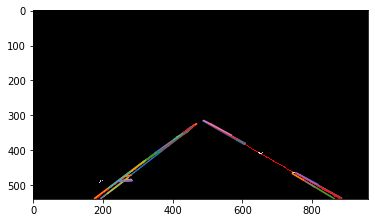

In [8]:
linesx = draw_lines(image, lines, [255, 0, 0], 2)
# Create a "color" binary image to combine with line image
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

# Draw the lines on the edge image
combox = cv2.addWeighted(color_edges, 0.8, linesx, 1, 0) 
plt.imshow(combox)


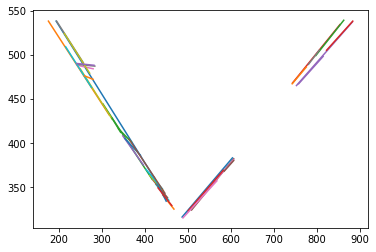

In [9]:
i = 0
a = [[0] * len(lines), [0] * len(lines)]
for pltline in lines:
    for x1,y1,x2,y2 in pltline:
        plt.plot([x1, x2], [y1, y2])
        a[0][i] = ((y2-y1)/(x2-x1))
        a[1][i] = ((y2-y1)**2 + (x2-x1)**2)**(1/2)
        i = i + 1

In [10]:
aPos = [i for i in a[0] if i > 0]
aPosLen = [a[1][a[0].index(i)] for i in a[0] if i > 0]
aNeg = [i for i in a[0] if i <= 0]
aNegLen = [a[1][a[0].index(i)] for i in a[0] if i <= 0]
aAveAbs = sum(list(map(abs, a[0])))/len(a[0])
#print(aAveAbs)
#print("lengths: ",len(a[0]) , len(aX))

In [11]:
aNegX = [i for i in aNeg if abs(abs(i)-aAveAbs)<0.2]
aNegLenX = [a[1][a[0].index(i)] for i in aNegX]
AveNegRate = [(i-min(aNegLenX))/(max(aNegLenX)-min(aNegLenX)) for i in aNegLenX]
aNegXRated = [i*aNegX[AveNegRate.index(i)] for i in AveNegRate]
SlopeNeg = sum(aNegXRated)/sum(AveNegRate)
#
aPosX = [i for i in aPos if abs(abs(i)-aAveAbs)<0.2]
aPosLenX = [a[1][a[0].index(i)] for i in aPosX]
AvePosRate = [(i-min(aPosLenX))/(max(aPosLenX)-min(aPosLenX)) for i in aPosLenX]
aPosXRated = [i*aPosX[AvePosRate.index(i)] for i in AvePosRate]
SlopePos = sum(aPosXRated)/sum(AvePosRate)
#
#print(SlopeNeg)
#print(SlopePos)

In [12]:
NegLines = [lines[a[0].index(i)] for i in aNegX]
i = 0
xyNeg = [[0] * len(NegLines), [0] * len(NegLines), [0] * len(NegLines), [0] * len(NegLines)]
for pltline in NegLines:
    for x1,y1,x2,y2 in pltline:
        xyNeg[0][i] = x1
        xyNeg[1][i] = x2
        xyNeg[2][i] = y1
        xyNeg[3][i] = y2
        i = i + 1
x1Neg = sum(xyNeg[0])/len(xyNeg[0])
x2Neg = sum(xyNeg[1])/len(xyNeg[0])
y1Neg = sum(xyNeg[2])/len(xyNeg[0])
y2Neg = sum(xyNeg[3])/len(xyNeg[0])
#plt.plot([x1Neg, x2Neg],[y1Neg, y2Neg])
#
PosLines = [lines[a[0].index(i)] for i in aPosX]
i = 0
xyPos = [[0] * len(PosLines), [0] * len(PosLines), [0] * len(PosLines), [0] * len(PosLines)]
for pltline in PosLines:
    for x1,y1,x2,y2 in pltline:
        xyPos[0][i] = x1
        xyPos[1][i] = x2
        xyPos[2][i] = y1
        xyPos[3][i] = y2
        i = i + 1
x1Pos = sum(xyPos[0])/len(xyPos[0])
x2Pos = sum(xyPos[1])/len(xyPos[0])
y1Pos = sum(xyPos[2])/len(xyPos[0])
y2Pos = sum(xyPos[3])/len(xyPos[0])
#plt.plot([x1Pos, x2Pos],[y1Pos, y2Pos])

In [13]:
inpsNeg = list(range(min(xyNeg[0]), max(xyNeg[1])))
youtNeg = [SlopeNeg*(i-x1Neg) + y1Neg for i in inpsNeg]
inpsPos= list(range(min(xyPos[0]), max(xyPos[1])))
youtPos = [SlopePos*(i-x1Pos) + y1Pos for i in inpsPos]
#plt.plot(inpsNeg,youtNeg)
#plt.plot(inpsPos,youtPos)

In [14]:
yMax = image.shape[0]
XStartNeg = int(((yMax-y1Neg)/SlopeNeg)+x1Neg)
XStartPos = int(((yMax-y1Pos)/SlopePos)+x1Pos)
inpsNeg = list(range(XStartNeg, max(xyNeg[1])))
youtNeg = [SlopeNeg*(i-x1Neg) + y1Neg for i in inpsNeg]
inpsPos= list(range(min(xyPos[0]), XStartPos))
youtPos = [SlopePos*(i-x1Pos) + y1Pos for i in inpsPos]

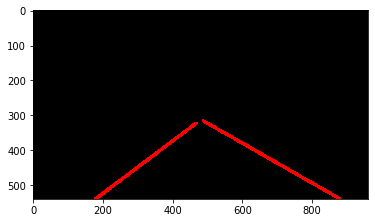

In [15]:
line_imagex = np.copy(image)*0
LinesNewx = [min(inpsNeg),max(inpsNeg),max(youtNeg),min(youtNeg)]
LinesNewx = [int(i) for i in LinesNewx]
cv2.line(line_imagex,(LinesNewx[0],LinesNewx[2]),(LinesNewx[1],LinesNewx[3]),(255,0,0),10)
LinesNewx = [min(inpsPos),max(inpsPos),min(youtPos),max(youtPos)]
LinesNewx = [int(i) for i in LinesNewx]
cv2.line(line_imagex,(LinesNewx[0],LinesNewx[2]),(LinesNewx[1],LinesNewx[3]),(255,0,0),10)
plt.imshow(line_imagex)

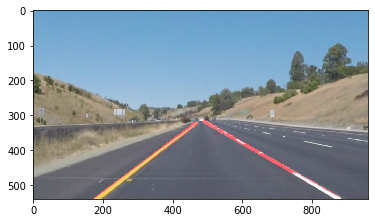

In [16]:
combox = cv2.addWeighted(color_edges, 0.8, line_imagex, 1, 0) 
plt.imshow(combox)
ResultImage = cv2.addWeighted(image, 1, line_imagex, 1, 0) 
plt.imshow(ResultImage)

In [17]:
imagex = cv2.imread('test_images/whiteCarLaneSwitch.jpg')
ResultImagex = cv2.addWeighted(imagex, 1, line_imagex, 1, 0) 
cv2.imshow('image',ResultImagex)
cv2.waitKey(0)

In [ ]:
#for file in os.listdir('test_images/'): image = mpimg.imread(directory+file)
#plt.imshow(image)

In [ ]:
#pip install opencv-python
#pip install moviepy